In [1]:
%load_ext autoreload
%autoreload 2


from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
from skimage.util import random_noise
from skimage import filters
from skimage.transform import rescale
from bpho import *

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
import torchvision.transforms as tvt

In [3]:
torch.cuda.set_device(1)

In [4]:
datasetname = 'mito_tiles'
data_path = Path('../')
datasets = data_path/'datasets'
datasources = data_path/'data'
dataset = datasets/datasetname

test_files = dataset/'test'
hr_tifs = dataset/'hr_t_512'
lr_up_tifs = dataset/'hr_t_512'

stats_inputs = Path('stats/input')
mname = 'combo'
model_dir = 'models'

loss = F.mse_loss
metrics = sr_metrics

In [5]:
def _down_up(x, scale=4):
    #set_trace()
    #x = x.numpy()
    
    x = F.interpolate(x[None], scale_factor=1/scale)[0]
    x = F.interpolate(x[None], scale_factor=scale)[0]
    return x

down_up = TfmPixel(_down_up)

def _my_noise(x, gauss_sigma=1., scale=4, pscale=12, gscale=0.0001):
    #set_trace()
    #x = x.numpy()
    
    x = F.interpolate(x[None], scale_factor=1/scale)[0]
    xn = x.numpy()
    xn = np.random.poisson(xn*pscale)/pscale
    xn += np.random.normal(0, gscale, size=x.shape)
    xn = np.maximum(0,xn)
    xn /= xn.max()
    x = x.new(xn)
    x = F.interpolate(x[None], scale_factor=scale)[0]
    return x
my_noise = TfmPixel(_my_noise)

def get_xy_transforms(max_rotate=10., min_zoom=1., max_zoom=2., use_cutout=False, use_noise=False, xtra_tfms = None):
    base_tfms = [[
            rand_crop(),
            dihedral_affine(),
            rotate(degrees=(-max_rotate,max_rotate)),
            rand_zoom(min_zoom, max_zoom)
        ],
        [crop_pad()]]

    y_tfms = [[tfm for tfm in base_tfms[0]], [tfm for tfm in base_tfms[1]]]
    x_tfms = [[tfm for tfm in base_tfms[0]], [tfm for tfm in base_tfms[1]]]
    if use_cutout: x_tfms[0].append(cutout(n_holes=(5,10)))
    if use_noise: x_tfms[0].append(my_noise())
    x_tfms[1].append(down_up())
    
    if xtra_tfms:
        for tfm in xtra_tfms:
            x_tfms[0].append(tfm)

    return x_tfms, y_tfms

def get_src(xy_data):
    src = (ImageImageList
            .from_folder(xy_data, convert_mode='L')
            .split_by_folder()
            .label_from_func(lambda x: x, convert_mode='L'))
    return src


def get_data(bs, size, xy_data, 
             max_rotate=10.,
             min_zoom=1., max_zoom=1.1, 
             use_cutout=False, 
             use_noise=False, 
             xtra_tfms=None, 
             **kwargs):
    
    src = get_src(xy_data)
    x_tfms, y_tfms = get_xy_transforms(
                          max_rotate=max_rotate, 
                          min_zoom=min_zoom, max_zoom=max_zoom, 
                          use_cutout=use_cutout, 
                          use_noise=use_noise, 
                          xtra_tfms = xtra_tfms)
    data = (src
            .transform(x_tfms, size=size)
            .transform_y(y_tfms, size=size)
            .databunch(bs=bs,**kwargs))#.normalize())
    data.c = 3
    return data

def do_fit(learn, save_name, lrs=slice(1e-3), pct_start=0.9, cycle_len=10):
    learn.to_fp16().fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    print(f'saved: {save_name}')
    num_rows = min(learn.data.batch_size, 3)
    learn.to_fp32().show_results(rows=num_rows, imgsize=5)

In [6]:
data = get_data(4, 512, hr_tifs, use_cutout=True, use_noise=True)

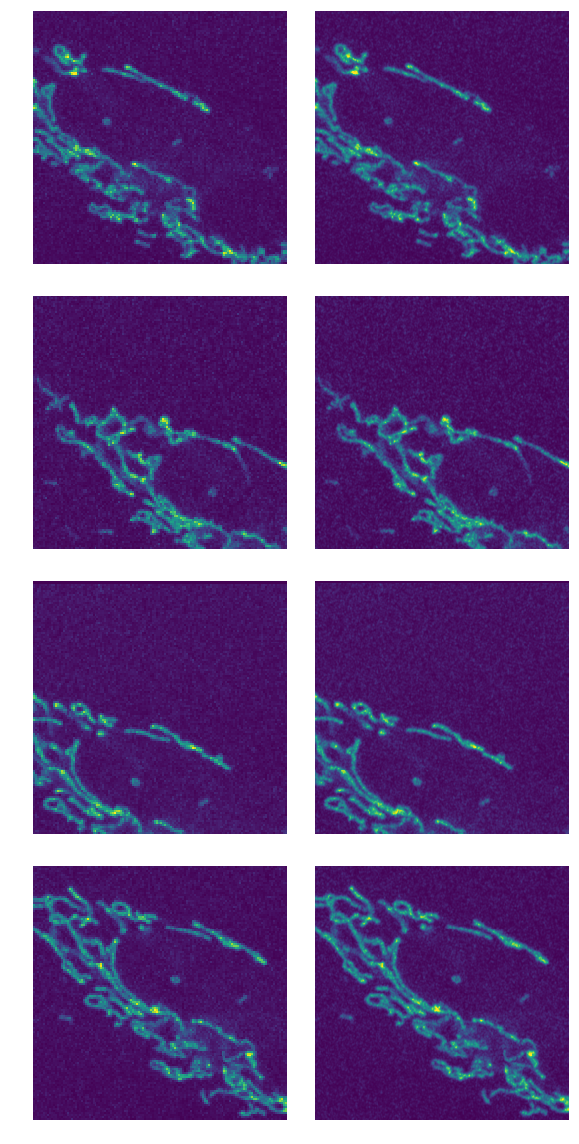

In [7]:
data.show_batch(ds_type=DatasetType.Valid)
    

In [8]:
step = 0
lr = 1e-3
cycles = 2
loss = F.l1_loss
metrics = sr_metrics


bs = 16
size = 256
use_cutout=True
use_noise=True
arch = xresnet18

data = get_data(bs, size, hr_tifs, use_cutout=use_cutout, use_noise=use_noise)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir, path='.')
gc.collect()

14984

In [9]:
#data.show_batch()

In [10]:
if False:
    learn.lr_find()
    learn.recorder.plot()

In [11]:
#data.train_ds.y.items[0]

In [12]:
#data.show_batch(3)

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.047965,0.031247,0.730942,24.856319,02:26
1,0.044560,0.032305,0.711230,25.419376,02:14


saved: combo.00


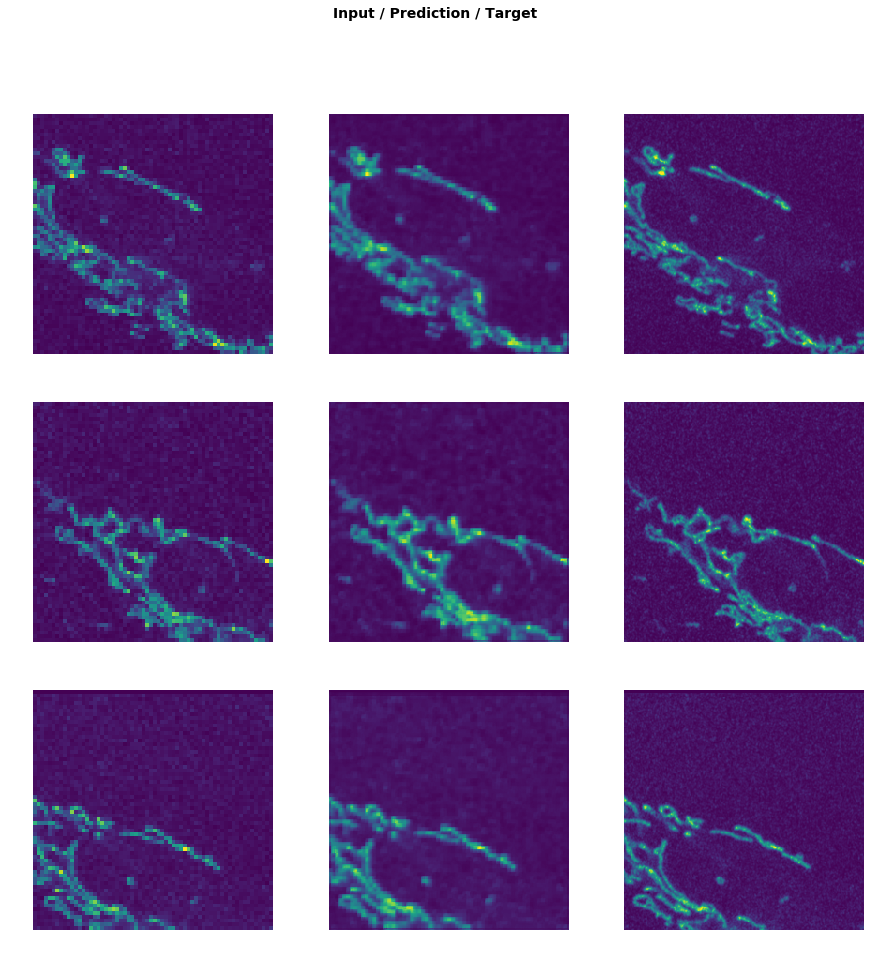

In [13]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [ ]:
step = 1
lr = 1e-4
cycles = 10
loss = F.l1_loss
metrics = sr_metrics


bs = 12
size = 512
max_zoom = 1.2
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir, path='.')
learn.load(f'{mname}.{(step-1):02d}')
gc.collect()


In [ ]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr/10, cycle_len=cycles)

In [ ]:
learn.unfreeze()
do_fit(learn, f'{mname}.{step:02d}', lrs=slice(lr/300, lr/10, None), cycle_len=cycles*3)

In [ ]:
hr_tifs = dataset/'hr_t_1024'
lr_up_tifs = dataset/'lrup_t_1024'


step = 0
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 2
size = 256
max_zoom = 1.2
arch = xresnet50

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom, num_workers=4)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir, path='.')
learn.load(f'{mname}.{(step-1):02d}')
gc.collect()

In [ ]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [ ]:
do_fit(learn, f'{mname}.{step:02d}.1', lrs=lr/50, cycle_len=cycles*5)

In [ ]:
p = Path('stats/input/mitotracker/')

test_fns = []

test_fns += list(p.glob('*.tif'))
test_fns += list(p.glob('**/**/*.czi'))

#test_fns = test_fns[0:1]

In [ ]:
test_fns

In [ ]:
#test_fns = []
#test_fns += list(test_files.glob('**/*.tif'))
#test_fns += list(test_files.glob('**/*.czi'))

In [ ]:
step = 0
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 1
size = 512
max_zoom = 2
arch = xresnet50

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir, path='.')
learn.load(f'combo2_best').to_fp16()
gc.collect()

In [ ]:
print('READY')

In [ ]:
dest = Path('/DATA/temp/')
shutil.rmtree(dest)
dest.mkdir(exist_ok=True, parents=True)
generate_tifs(test_fns, dest, learn, size, tag=mname, max_imgs=10)

In [ ]:
#test = PIL.Image.open('/DATA/temp/actin/C2-low lres confocal mito and actin 3_combo_orig.tif')

In [ ]:
9*256

In [ ]:
learn.export('combotile.pkl')

In [ ]:
learn.path

In [ ]:
shutil.copy?

In [ ]:
learn.path = Path('.')

In [ ]:
import czifile
from pathlib import Path
from fastprogress import progress_bar
import pandas as pd
import numpy as np
import PIL.Image
from bpho import *
PIL.Image.MAX_IMAGE_PIXELS = 99999999999999

In [ ]:


p = Path('data/')
fns = list(p.glob('**/mitotracker/**/*.czi'))
print(len(fns))
fn = fns[0]

In [ ]:
info = []
for fn in progress_bar(fns):
     with PIL.Image.open(fn) as tif_f:
        img = np.array(tif_f)
        info.append({'fn': fn, 'category': fn.parts[-3],
                     'ndtype': img.dtype})
df = pd.DataFrame(info)

In [ ]:
df

In [ ]:
f = fns[50]

In [ ]:
!ls data/fixed

In [ ]:
!ls data/fixed/fixed_cell_mitochondria/train

In [ ]:
tif_f = PIL.Image.open(fn)
a = np.array(tif_f)
a.shape

In [ ]:
mi,ma = np.percentile(a, [2,99.8])
print(mi,ma)

In [ ]:
eps = 1e-20 
a = (a - mi) / (ma - mi + eps)

In [ ]:
from fastai import *
from fastai.vision import *
img = Image(tensor(a[None]))

In [ ]:
img

In [ ]:
info = []
for fn in progress_bar(fns):
    if fn.parts[-4] != 'random' and 'great quality' not in fn.stem:
        try:
            with czifile.CziFile(fn) as czi_f:
                data = czi_f.asarray()                
                mi, ma = np.percentile(data, [2, 99.8])
                info.append({'fn': fn, 'ndtype': czi_f.dtype, 'category': fn.parts[-3],
                             'maxval': data.max(), 'mi': mi, 'ma': ma})
        except:
            print('exception', fn)
            pass
df = pd.DataFrame(info)

In [ ]:
df.columns = ['category', 'dtype', 'fn', 'maxval']

In [ ]:
mi, ma = np.percentile(data, [2, 99.8])

In [ ]:
ndata = (data - mi)

In [ ]:
mi

In [ ]:
df

In [ ]:
czi_f = czifile.CziFile(fn)

In [ ]:
data = czi_f.asarray()

In [ ]:
data.dtype, data.shape

In [ ]:
proc_axes, proc_shape = get_czi_shape_info(czi_f)
idx = build_index(proc_axes, {'X': slice(0,18975), 'Y': slice(0,18886)})


In [ ]:
np.percentile(data, 10)

In [ ]:
czi_f.metadata

In [ ]:
%pylab inline

In [ ]:
2**10

In [ ]:
2**12

In [ ]:
2*14

In [ ]:
2**14

In [ ]:
2**13

In [ ]:
df